Scale: Just downtown


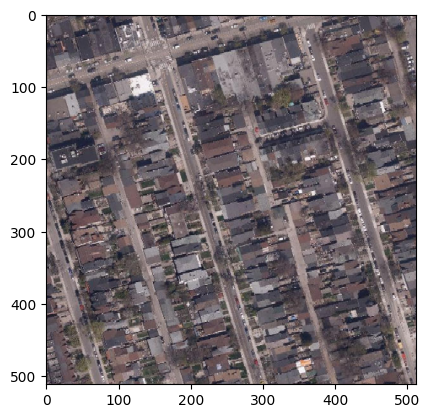

(3, 512, 512)


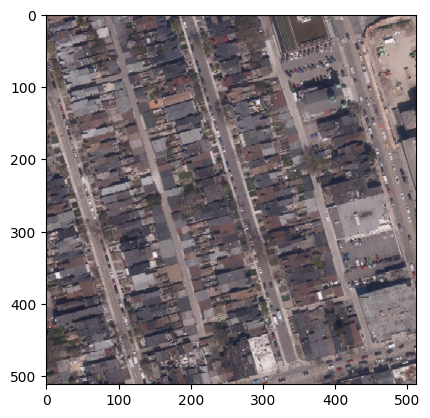

(3, 512, 512)


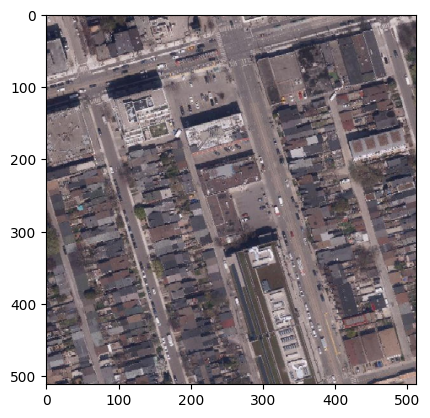

(3, 512, 512)


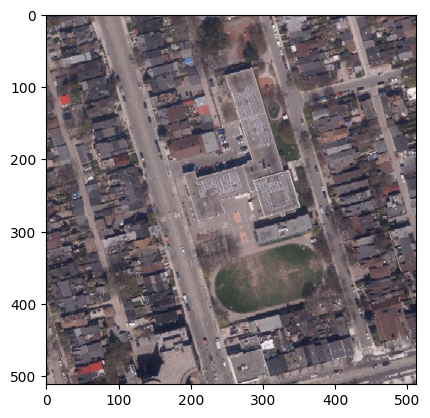

(3, 512, 512)


In [ ]:
from owslib.wms import WebMapService
import requests
from PIL import Image
from io import BytesIO
import rasterio
import rasterio.plot
import numpy as np
from pyproj import Transformer

wms_url = "https://gis.toronto.ca/arcgis/services/basemap/cot_ortho/MapServer/WMSServer"
wms = WebMapService(wms_url)

bbox = (-79.393558267, 43.652245064, -79.390323394, 43.654593845)
width, height = 512, 512
layer = "0"

response = requests.get(wms_url, params={
   'service': 'WMS',
   'version': '1.1.1',
   'request': 'GetMap',
   'layers': layer,
   'styles': '',
   'bbox': ','.join(map(str, bbox)),
   'width': width,
   'height': height,
   'srs': 'EPSG:4326',
   'format': 'image/tiff'
})

with rasterio.open(BytesIO(response.content)) as src: 
    #rasterio.plot.show(src)
    image1 = src.read()

def request_slice(bbox, resolution=512):
    response = requests.get(wms_url, params={
        'service': 'WMS',
        'version': '1.1.1',
        'request': 'GetMap',
        'layers': '0',
        'styles': '',
        'bbox': ','.join(map(str, bbox)),
        'width': resolution,
        'height': resolution,
        'srs': 'EPSG:4326',
        'format': 'image/tiff'
    })

    with rasterio.open(BytesIO(response.content)) as src:
        image = src.read()
        meta = src.meta.copy()
    
    return image, meta

experiment_scale = "256x10"

# Define latlong - utm transforms
to_utm = Transformer.from_crs("EPSG:4326", "EPSG:32617", always_xy=True)
to_latlon = Transformer.from_crs("EPSG:32617", "EPSG:4326", always_xy=True)

match experiment_scale:
    case "256x10":
        # Just Downtown
        print("Scale: Just downtown")
        min_lon, max_lon = -79.4094857791984339, -79.3771331162286344
        min_lat, max_lat = 43.6497614709130204, 43.6732489456111850
    case _:
        # Full Extent of Toronto 
        min_lon, max_lon = -79.6799539999999951, -79.0702129999999954
        min_lat, max_lat = 43.5483800000000016, 43.9100490000000008

# To UTM
min_x, min_y = to_utm.transform(min_lon, min_lat)
max_x, max_y = to_utm.transform(max_lon, max_lat)

# Set coords
step = 256
x_coords = np.arange(min_x, max_x, step)
y_coords = np.arange(min_y, max_y, step)

go_for = 4
for x in x_coords:
    if go_for <= 0: break
    for y in y_coords:
        if go_for <= 0: break 
        ul_lon, ul_lat = to_latlon.transform(x, y + step)
        lr_lon, lr_lat = to_latlon.transform(x + step, y)

        image, _ = request_slice([ul_lon, lr_lat, lr_lon, ul_lat])
        rasterio.plot.show(image)
        print(image.shape)
        go_for -= 1